# A simple neural network with one hidden layer in pure Python

## Introduction
We consider a simple feed-forward neural network with one hidden layer:

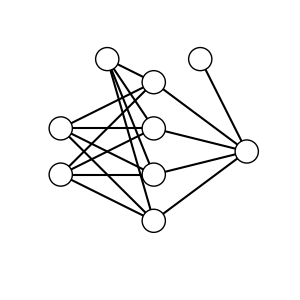

In this example the input vector of the neural network has two features, i.e., the input is a two-dimensional vector:

$$
\mathbf x = (x_0, x_1).
$$

We consider a set of $n$ vectors as training data. The training data can therefore be written as a $n \times 2$ matrix where each row represents a feature vector:

$$ 
X = 
\begin{pmatrix}
x_{00} & x_{01} \\
x_{10} & x_{11} \\
\vdots & \vdots \\
x_{m-1\,0} & x_{m-1\,1} 
\end{pmatrix} $$

The known labels (1 = 'signal', 0 = 'background') are stored in a $n$-dimensional column vector $\mathbf y$.

In the following, $n_1$ denotes the number of neurons in the hidden layer. The weights for the connections from the input layer (layer 0) to the hidden layer (layer 0) are given by the following matrix:

$$
W^{(1)} = 
\begin{pmatrix}
w_{00}^{(1)} \dots w_{0 \, n_1-1}^{(1)} \\
w_{10}^{(1)} \dots w_{1 \, n_1-1}^{(1)} 
\end{pmatrix}
$$

Each neuron in the hidden layer is assigned a bias $\mathbf b^{(1)} = (b^{(1)}_0, \ldots, b^{(1)}_{n_1-1})$. The neuron in the output layer has the bias $\mathbf b^{(2)}$. With that, the output values of the network for the matrix $X$ of input feature vectors is given by

$$
\begin{align}
Z^{(1)} &= X W^{(1)} + \mathbf b^{(1)} \\
A^{(1)} &= \sigma(Z^{(1)}) \\
Z^{(2)} &= A^{(1)} W^{(2)} + \mathbf b^{(2)} \\
A^{(2)} &= \sigma(Z^{(2)})
\end{align}
$$

The loss function for a given set of weights is given by

$$ L = \sum_{i=0}^{n-1} (y_\mathrm{pred} - y_\mathrm{true})^2 $$

We can know calculate the gradient of the loss function w.r.t. the wights. With the definition $\hat L = (y_\mathrm{pred} - y_\mathrm{true})^2$, the gradients for the weights from the output layer to the hidden layer are given by: 

$$ \frac{\partial \tilde L}{\partial w_i^{(2)}} = \frac{\partial \tilde L}{a_k^{(2)}} \frac{a_k^{(2)}}{\partial w_i^{(2)}} = \frac{\partial \tilde L}{a_k^{(2)}} \frac{a_k^{(2)}}{z_k^{(2)}} \frac{z_k^{(2)}}{\partial w_i^{(2)}} = 2 (a_k^{(2)} - y_k) a_k^{(2)} (1 - a_k^{(2)}) a_{k,i}^{(1)}$$

Applying the chain rule further, we also obtain the gradient for the weights from the input layer to the hidden layer read: 

$$ \frac{\partial \tilde L}{\partial w_{ij}^{(1)}} = \frac{\partial \tilde L}{\partial a_k^{(2)}} \frac{\partial a_k^{(2)}}{\partial z_k^{(2)}} \frac{\partial z_k^{(2)}}{\partial a_{k,j}^{(1)}} \frac{\partial a_{k,j}^{(1)}}{\partial z_{k,j}^{(1)}} \frac{\partial z_{k,j}^{(1)}}{\partial w_{ij}^{(1)}} $$

## A simple neural network class

In [1]:
# A simple feed-forward neutral network with on hidden layer
# see also https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6

import numpy as np

class NeuralNetwork:
    def __init__(self, x, y):
        n1 = 3 # number of neurons in the hidden layer
        self.input         = x
        self.weights1      = np.random.rand(self.input.shape[1],n1)
        self.bias1         = np.random.rand(n1)
        self.weights2      = np.random.rand(n1,1)
        self.bias2         = np.random.rand(1)                 
        self.y             = y
        self.output        = np.zeros(y.shape)
        self.learning_rate = 0.01
        self.n_train       = 0
        self.loss_history  = []

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def feedforward(self):
        self.layer1 = self.sigmoid(self.input @ self.weights1 + self.bias1)
        self.output = self.sigmoid(self.layer1 @ self.weights2 + self.bias2)

    def backprop(self):

        # delta1: [m, 1], m = number of training data
        delta1 = 2 * (self.y - self.output) * self.sigmoid_derivative(self.output)

        # Gradient w.r.t. weights from hidden to output layer: [n1, 1] matrix, n1 = # neurons in hidden layer
        d_weights2 = self.layer1.T @ delta1
        d_bias2    = np.sum(delta1) 
    
        # shape of delta2: [m, n1], m = number of training data, n1 = # neurons in hidden layer
        delta2     = (delta1 @ self.weights2.T) * self.sigmoid_derivative(self.layer1)
        d_weights1 = self.input.T @ delta2
        d_bias1    = np.ones(delta2.shape[0]) @ delta2 
        
        # update weights and biases
        self.weights1 += self.learning_rate * d_weights1
        self.weights2 += self.learning_rate * d_weights2

        self.bias1    += self.learning_rate * d_bias1
        self.bias2    += self.learning_rate * d_bias2

    def train(self, X, y):
        self.output = np.zeros(y.shape)
        self.input = X
        self.y = y
        self.feedforward()
        self.backprop()
        self.n_train += 1
        if (self.n_train %1000 == 0):
            loss = np.sum((self.y - self.output)**2)
            print("loss: ", loss)
            self.loss_history.append(loss)
    
    def predict(self, X):
        self.output = np.zeros(y.shape)
        self.input = X
        self.feedforward()
        return self.output
    
    def loss_history(self):
        return self.loss_history


## Create toy data
We create three toy data sets
1. two moon-like distributions
2. circles
3. linearly separable data sets

In [2]:
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(n_samples=200, noise=0.1, random_state=0),
    make_circles(n_samples=200, noise=0.1, factor=0.5, random_state=1),
    linearly_separable,
]

## Create training and test data set

In [3]:
# datasets: 0 = moons, 1 = circles, 2 = linearly separable
X, y = datasets[1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42
)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5


## Train the model

In [4]:
y_train = y_train.reshape(-1, 1)

nn = NeuralNetwork(X_train, y_train)

for i in range(100000):
    nn.train(X_train, y_train)


loss:  28.591431249971087
loss:  19.174944855091578
loss:  18.300519116661075
loss:  5.44035901972833
loss:  2.2654992441410906
loss:  1.6923656607186892
loss:  1.3715971480249087
loss:  1.1473150221090382
loss:  0.9774346378363713
loss:  0.8457117685917934
loss:  0.7429652120737472
loss:  0.6621808985042399
loss:  0.5977165926831687
loss:  0.545283043346378
loss:  0.5017902977940301
loss:  0.46506515287723293
loss:  0.4335772706016494
loss:  0.40623169342909965
loss:  0.3822273847227754
loss:  0.36096446182458697
loss:  0.3419836665195889
loss:  0.3249263905044797
loss:  0.3095077414631703
loss:  0.29549797484687557
loss:  0.282709394404349
loss:  0.27098690712728085
loss:  0.2602010759266338
loss:  0.2502429170283057
loss:  0.24101994107129043
loss:  0.23245309736167535
loss:  0.2244743850815736
loss:  0.2170249645242441
loss:  0.21005364833790718
loss:  0.2035156851277511
loss:  0.19737177048767093
loss:  0.19158723674048994
loss:  0.18613138439559326
loss:  0.1809769269368725
loss:

## Plot the loss vs. the number of epochs

Text(0, 0.5, 'loss')

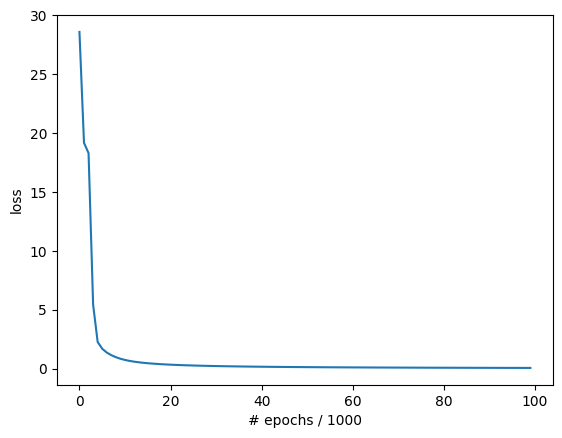

In [5]:
import matplotlib.pyplot as plt
plt.plot(nn.loss_history)
plt.xlabel("# epochs / 1000")
plt.ylabel("loss")

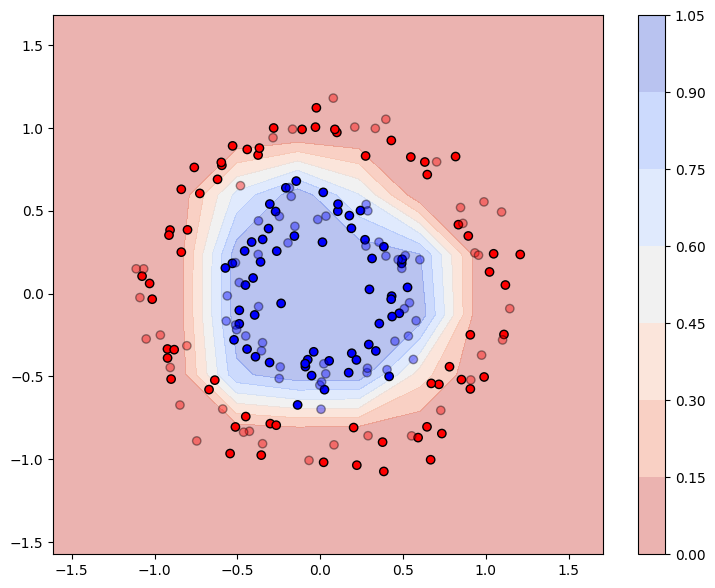

In [6]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])

xv = np.linspace(x_min, x_max, 10)
yv = np.linspace(y_min, y_max, 10)
Xv, Yv = np.meshgrid(xv, yv)
XYpairs = np.vstack([ Xv.reshape(-1), Yv.reshape(-1)])
zv = nn.predict(XYpairs.T)
Zv = zv.reshape(Xv.shape)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 7))
ax.set_aspect(1)
cn = ax.contourf(Xv, Yv, Zv, cmap="coolwarm_r", alpha=0.4)

ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")

# Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.4, edgecolors="k")

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
# ax.set_xticks(())
# ax.set_yticks(())

fig.colorbar(cn)
